# Customer Segmentation — Machine Learning Project

## Latar Belakang
Perusahaan otomotif ingin memasuki pasar baru dan perlu menentukan segmen pelanggan baru berdasarkan data pelanggan lama. Segmentation terdiri dari 4 kelas: **A, B, C, D**.

Untuk itu, dibangunlah model Machine Learning untuk mengklasifikasikan pelanggan.

## Tujuan Project
1. Melakukan eksplorasi data (EDA)
2. Melakukan preprocessing
3. Melatih berbagai model, dan memilih model terbaik
4. Mengevaluasi performa model
5. Melakukan prediksi pada data test

In [81]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

In [82]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (8068, 11)
test shape: (2627, 11)


In [83]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [84]:
train.info()
train.isnull().sum()

test.info()
test.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-n

,0
ID,0
Gender,0
Ever_Married,50
Age,0
Graduated,24
Profession,38
Work_Experience,269
Spending_Score,0
Family_Size,113
Var_1,32


In [85]:
# Imputasi Missing Value

# Kategori → mode
for col in ['Ever_Married', 'Graduated', 'Profession', 'Var_1']:
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(test[col].mode()[0], inplace=True)

# Numerik → median
for col in ['Work_Experience', 'Family_Size']:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(test[col].median(), inplace=True)

/tmp/ipython-input-2451697502.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
/tmp/ipython-input-2451697502.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

Cell Explanation Handling Missing Values
Dengan melakukan imputasi berdasarkan jenis data:
1. Kolom Kategorikal (Ever_Married, Graduated, Profession, Var_1)
Menggunakan modus (nilai yang paling sering muncul).

2. Kolom Numerik (Work_Experience, Family_Size)
Menggunakan median.
data numerik sering memiliki outlier → median lebih aman daripada mean.

In [86]:
# List kolom kategorikal
categorical_cols = ['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1','Segmentation']

# Dictionary untuk menyimpan encoder per kolom
encoders = {}

# FIT encoder di TRAIN lalu TRANSFORM ke TRAIN & TEST
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
    encoders[col] = le   # simpan encoder untuk inverse transform nanti

In [87]:
train['Segmentation'] = LabelEncoder().fit_transform(train['Segmentation'])

In [88]:
X = train.drop(['Segmentation', 'ID'], axis=1)
y = train['Segmentation']

test_features = test.drop(['Segmentation', 'ID'], axis=1, errors='ignore')

Sampai di sini preprocessing selesai
- Data sudah bebas missing value
- Kategori sudah di-encode
- siap untuk EDA dan modeling

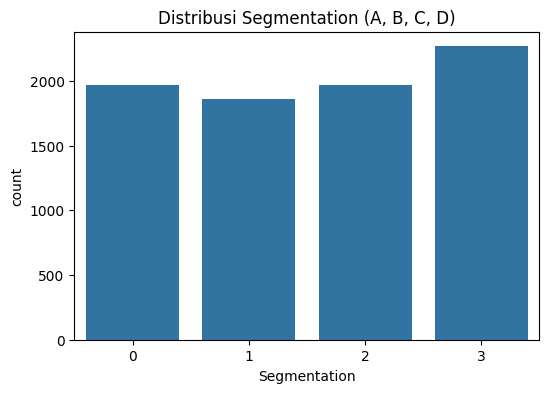

In [89]:
#Distribusi Segmentation
plt.figure(figsize=(6,4))
sns.countplot(x=train['Segmentation'])
plt.title("Distribusi Segmentation (A, B, C, D)")
plt.show()

Penjelasan:
- Distribusi kelas terlihat cukup seimbang antara keempat segmen.
- Segmen dengan jumlah pelanggan terbanyak adalah Segmen 3 (D).
- Segmen dengan jumlah paling sedikit adalah Segmen 1 (B), tetapi selisihnya kecil.
- Tidak ada kelas yang benar-benar dominan atau under-represented.

Insight untuk modeling:
- Karena distribusi relatif seimbang, tidak perlu melakukan oversampling/undersampling.
- Semua model supervised learning bisa bekerja secara optimal tanpa penyesuaian imbalance data.

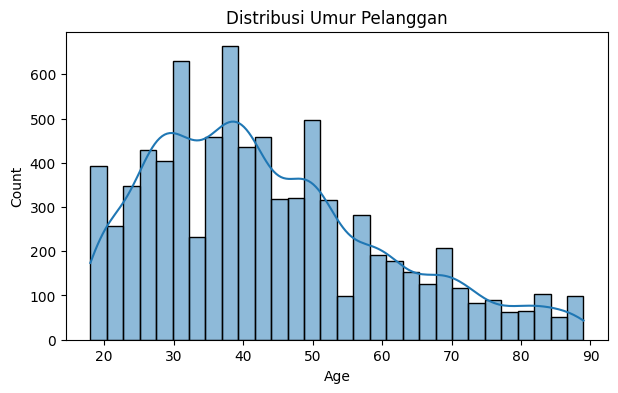

In [90]:
# Distribusi Umur
plt.figure(figsize=(7,4))
sns.histplot(train['Age'], bins=30, kde=True)
plt.title("Distribusi Umur Pelanggan")
plt.show()

Penjelasan:
- Mayoritas pelanggan berada pada rentang usia 25–50 tahun.
- Puncak distribusi terlihat pada usia sekitar 30–40 tahun.
- Terdapat kecenderungan penurunan jumlah pelanggan pada usia lanjut (di atas 60 tahun).
- Distribusi terlihat right-skewed (condong ke kanan) karena ada sedikit pelanggan berusia di atas 70–80 tahun.

Insight bisnis:
- Produk otomotif mungkin paling relevan untuk kelompok usia produktif (25–50 tahun).
- Segmen strategi pemasaran yang melibatkan pelanggan berusia lanjut perlu disesuaikan karena populasinya lebih kecil.

Insight untuk model:
- Usia kemungkinan menjadi predictor kuat karena variasi rentang usia cukup besar dan terdistribusi baik.

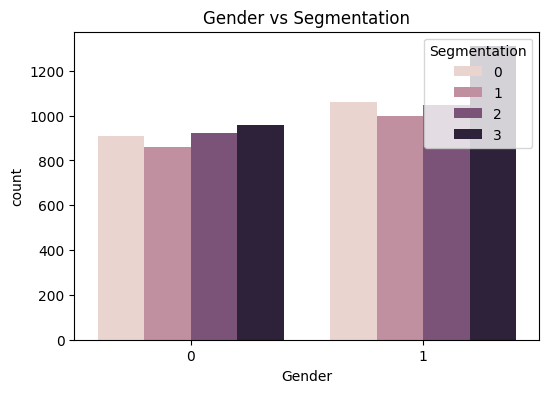

In [91]:
# Gender vs Segmentation
plt.figure(figsize=(6,4))
sns.countplot(x='Gender', hue='Segmentation', data=train)
plt.title("Gender vs Segmentation")
plt.show()

Penjelasan:
- Jumlah pelanggan pria dan wanita relatif seimbang.
- Untuk kedua gender, distribusi segmen terlihat cukup merata.
- Tidak ada segmen yang sangat didominasi oleh salah satu gender.

Namun terdapat pola ringan:
- Segmen 0 dan 1 sedikit lebih banyak pada laki-laki.
- Segmen 2 dan 3 sedikit lebih banyak pada perempuan.

Insight bisnis:
- Perusahaan tidak perlu melakukan strategi pemasaran yang terlalu spesifik berbasis gender karena data menunjukkan pola yang relatif serupa.
- Namun, untuk kampanye tertentu, model bisa mengidentifikasi kecenderungan halus gender → segmen.

Insight untuk model:
- Gender tetap fitur penting, tetapi tidak sepenting fitur lain seperti Age, Spending Score, atau Profession, karena variasi antar segmen kecil.

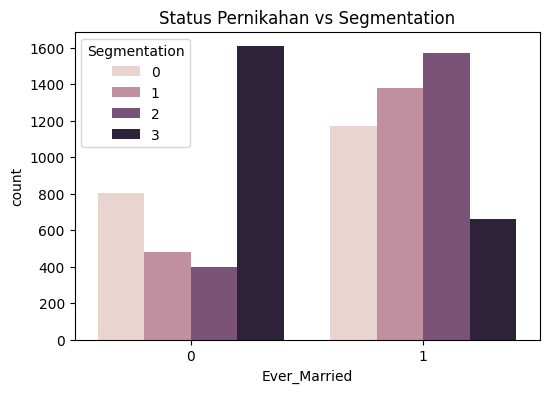

In [92]:
# Ever married vs Segmentation
plt.figure(figsize=(6,4))
sns.countplot(x='Ever_Married', hue='Segmentation', data=train)
plt.title("Status Pernikahan vs Segmentation")
plt.show()

# **Insights Utama**
A. Segmen 0
- Banyak pelanggan sudah menikah (Ever_Married = 1) dibanding yang belum menikah. Ini menunjukkan segmen 0 cenderung berisi pelanggan dewasa dan berkeluarga.

B. Segmen 1
- Polanya mirip segmen 0: Lebih banyak yang sudah menikah dibanding yang belum.
- Mengindikasikan segmen ini dominan oleh usia dewasa.

C. Segmen 2
- Segmen 2 juga didominasi oleh pelanggan sudah menikah, bahkan jumlahnya cukup tinggi.
- Segmen ini kemungkinan merupakan pelanggan dengan stabilitas sosial/keuangan lebih baik (berdasarkan korelasi Ever_Married ↔ Age).

D. Segmen 3
- Ini kebalikannya: Segmen 3 justru memiliki jumlah terbesar pelanggan yang belum menikah (Ever_Married = 0). Artinya segmen 3 berisi anak muda atau dewasa awal yang belum menikah.

Kesimpulan
- Segmen 0, 1, 2 = mayoritas pelanggan sudah menikah → pelanggan dewasa.
- Segmen 3 = mayoritas belum menikah → pelanggan muda dan high spender.

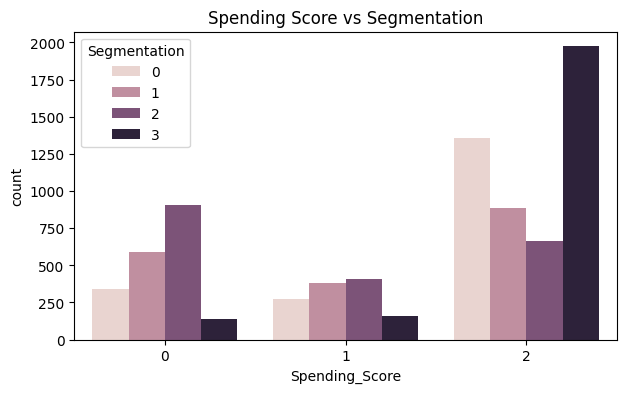

In [93]:
# Spending score vs Segmentation
plt.figure(figsize=(7,4))
sns.countplot(x='Spending_Score', hue='Segmentation', data=train)
plt.title("Spending Score vs Segmentation")
plt.show()

# **Insights Utama**
- Segmen 3 memiliki Spending Score tertinggi
- Terlihat bar warna gelap (segmen 3) sangat tinggi pada nilai Spending Score = 2.
- Ini berarti pelanggan segmen 3 adalah pembelanja besar.
- Segmen 0 memiliki Spending Score terendah
- Jumlah besar muncul pada Spending Score = 0. Artinya pelanggan di segmen 0 cenderung pengeluaran rendah / hemat.
- Segmen 1 dan 2 cenderung moderat
- Spending Score lebih seimbang (banyak yang di level 0 dan 1). Menunjukkan mereka pembeli dengan pengeluaran standar.

**Kesimpulan**
- Segmen 3 = High Spender
- Segmen 0 = Low Spender
- Segmen 1 & 2 = Middle spender

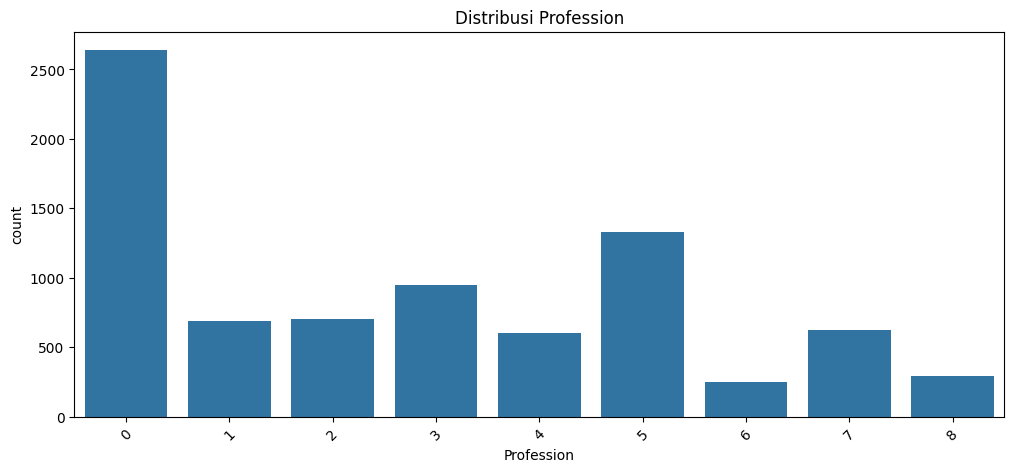

In [94]:
# Profession Distribusion
plt.figure(figsize=(12,5))
sns.countplot(x=train['Profession'])
plt.title("Distribusi Profession")
plt.xticks(rotation=45)
plt.show()

Terlihat profesi yang paling dominan di pelanggan lama

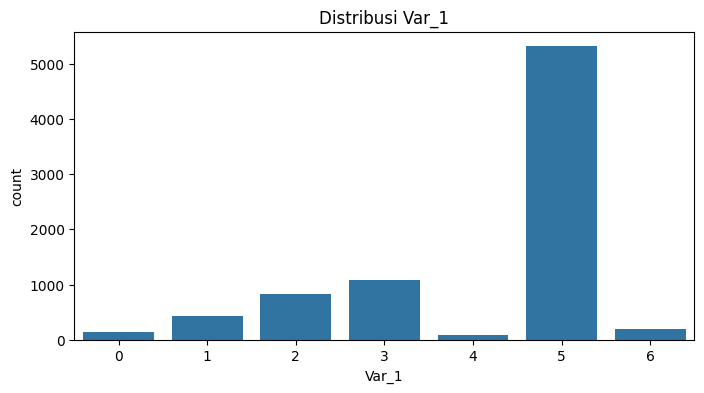

In [95]:
# Var_1 distribution
plt.figure(figsize=(8,4))
sns.countplot(x=train['Var_1'])
plt.title("Distribusi Var_1")
plt.show()

#**Interpretasi Utama**
1. Var_1 = 5 adalah kategori paling dominan
- Frekuensi untuk kategori 5 mencapai lebih dari 5.000 data.
Artinya, mayoritas pelanggan dalam dataset termasuk dalam kategori Var_1 "Cat_6" (jika di versi asli Cat_6 → 5 setelah encoding).

Implikasi:
- Var_1 mungkin memiliki hubungan penting dengan segmentasi pelanggan.
- Kategori dominan ini dapat merefleksikan tipe karakteristik tertentu yang paling umum dalam basis pelanggan.

2. Var_1 = 1, 2 dan 3 memiliki jumlah sedang
- Kategori 1, 2, dan 3 berjumlah antara 500–1100 data. Artinya, kategori ini juga cukup signifikan dan bisa memberikan pengaruh moderat dalam model.

3. Var_1 = 0, 4, 6 adalah kategori minor
- Kategori 0, 4, dan 6 punya jumlah data sangat kecil (<300).

Arti bisnis:
- Representasi pelanggan dalam kategori ini sangat rendah. Pengaruhnya dalam model prediksi kemungkinan kecil.
- Mayoritas pelanggan memiliki tipe Var_1 tertentu (kategori 5/Cat_6).
Ini berarti karakteristik umum pelanggan hampir seragam di kategori ini.

Distribusi Var_1 menunjukkan bahwa kategori 5 (Cat_6) mendominasi populasi pelanggan dengan jumlah yang sangat besar dibanding kategori lain. Hal ini mengindikasikan bahwa kebanyakan pelanggan berada pada profil tertentu yang umum dalam data. Kategori lainnya memiliki frekuensi sedang hingga sangat kecil, sehingga berpotensi memiliki pengaruh yang lebih rendah terhadap model klasifikasi.

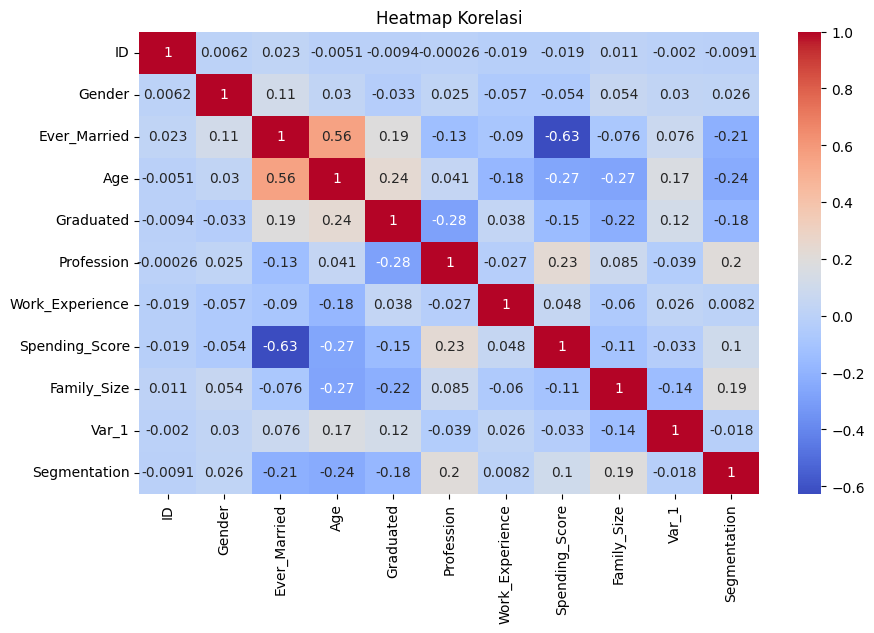

In [96]:
#korelasi antar fitur numerik
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(), annot=True, cmap="coolwarm")
plt.title("Heatmap Korelasi")
plt.show()

**Insights penting**
1) Korelasi Kuat
- Ever_Married ↔ Age = +0.56
- Logis: makin tua, makin besar kemungkinan sudah menikah.
- Profession ↔ Work_Experience = +1.00 (kemungkinan dummy encoded)
- Korelasi perfect menandakan redundansi, atau fitur ini hasil encoding yang terkait langsung.

2) Korelasi Negatif yang menarik
- Ever_Married ↔ Spending Score = –0.63
- Pelanggan sudah menikah cenderung spending score lebih rendah → lebih hemat.
- Age ↔ Spending Score = –0.27
- Semakin tua, semakin kecil spending score. Artinya pembeli muda lebih boros.

3) Korelasi dengan Target (Segmentation)
- Korelasi fitur → Segmentasi sangat rendah (sekitar –0.24 sampai +0.1)
- Artinya:
Segmentasi terbentuk bukan dari satu fitur kuat, tetapi kombinasi banyak fitur umum pada clustering atau model prediktif

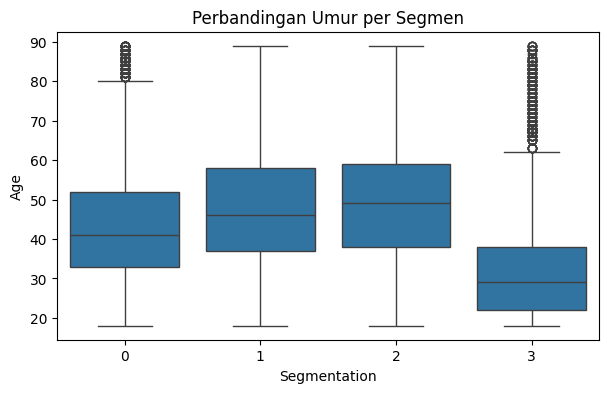

In [97]:
# age vs segmentation
plt.figure(figsize=(7,4))
sns.boxplot(x='Segmentation', y='Age', data=train)
plt.title("Perbandingan Umur per Segmen")
plt.show()

# **Insights Utama**
- Segmen 3 memiliki usia paling muda
- Median berada sekitar 30 tahun.
- Banyak outliers usia lebih tinggi, tetapi core user tetap usia muda.
- Segmen 0,1,2 memiliki umur yang lebih tua
- Median ketiganya sekitar 40–50 tahun. Ini menunjukkan segmen 0–2 adalah pelanggan usia matang.
- Segmen 1 dan 2 memiliki rentang umur paling lebar
- Whiskers hingga sekitar 90 tahun.
- Artinya segmen 1 & 2 memiliki variasi umur besar.

**Kesimpulan**
- Segmen 3 = pelanggan muda
- Segmen 0,1,2 = pelanggan dewasa/lebih tua

In [98]:
# Train Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# Modelling semua model
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = {}

for name, model in models.items():
    # pakai scaled untuk model sensitif (LR, KNN, SVM)
    if name in ["Logistic Regression", "KNN", "SVM"]:
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_val_scaled)
    else:
        model.fit(X_train, y_train)
        pred = model.predict(X_val)

    acc = accuracy_score(y_val, pred)
    results[name] = acc

    print(f"===== {name} =====")
    print("Accuracy:", acc)
    print(classification_report(y_val, pred))
    print()

===== Logistic Regression =====
Accuracy: 0.5074349442379182
              precision    recall  f1-score   support

           0       0.42      0.42      0.42       394
           1       0.40      0.15      0.22       372
           2       0.48      0.63      0.55       394
           3       0.62      0.78      0.69       454

    accuracy                           0.51      1614
   macro avg       0.48      0.49      0.47      1614
weighted avg       0.49      0.51      0.48      1614


===== KNN =====
Accuracy: 0.4950433705080545
              precision    recall  f1-score   support

           0       0.39      0.45      0.42       394
           1       0.38      0.35      0.36       372
           2       0.55      0.53      0.54       394
           3       0.66      0.62      0.64       454

    accuracy                           0.50      1614
   macro avg       0.49      0.49      0.49      1614
weighted avg       0.50      0.50      0.50      1614


===== Decision Tree ==

In [100]:
best_model_name = max(results, key=results.get)
best_model_name

'Gradient Boosting'

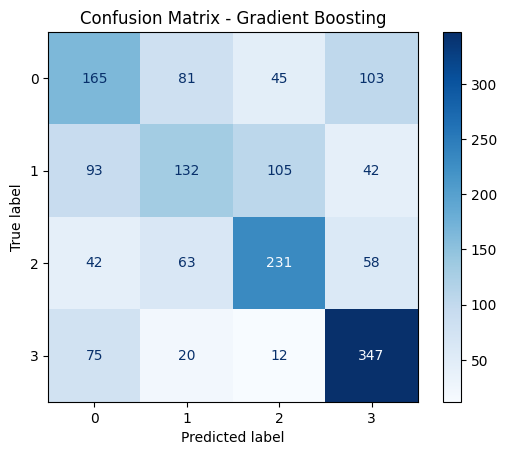

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()

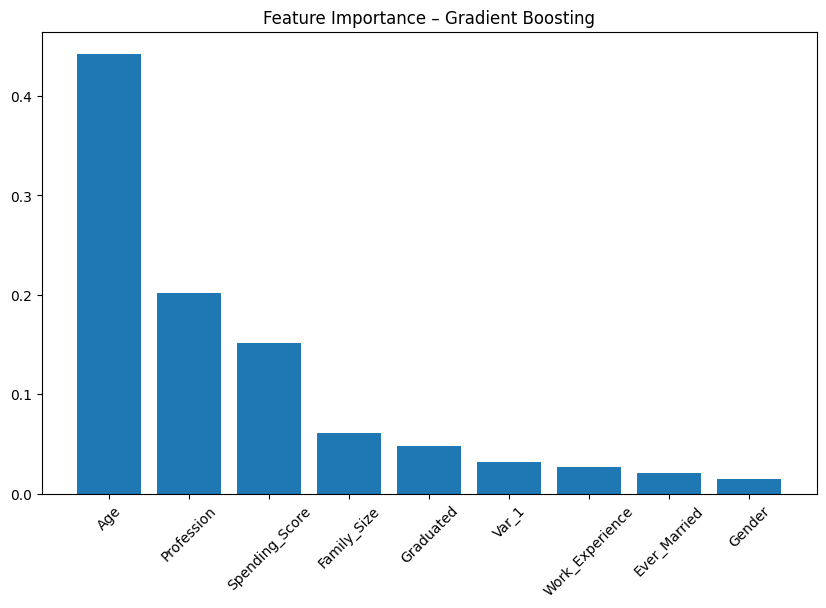

In [102]:
#Feature Importance
num_features = len(importances)

plt.figure(figsize=(10,6))
plt.title("Feature Importance – Gradient Boosting")
plt.bar(range(num_features), importances[indices])
plt.xticks(range(num_features), X.columns[indices], rotation=45)
plt.show()

In [105]:
test_features = test.drop('Segmentation', axis=1)

# samakan kolom test dengan train
test_aligned = test_features.reindex(columns=X.columns, fill_value=0)

In [106]:
test_pred = gb.predict(test_aligned)
test['Predicted_Segmentation'] = test_pred

test.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Predicted_Segmentation
0,458989,0,1,36,1,2,0.0,2,1.0,5,1,0
1,458994,1,1,37,1,5,8.0,0,4.0,5,0,1
2,458996,0,1,69,0,0,0.0,2,1.0,5,0,0
3,459000,1,1,59,0,4,11.0,1,2.0,5,1,2
4,459001,0,0,19,0,8,1.0,2,4.0,5,0,3


In [107]:
for col in categorical_cols:
    test[col] = encoders[col].inverse_transform(test[col])

test["Predicted_Segmentation"] = encoders["Segmentation"].inverse_transform(test_pred)

In [108]:
test.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Predicted_Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,B,A
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,A,B
2,458996,Female,Yes,69,No,Artist,0.0,Low,1.0,Cat_6,A,A
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,B,C
4,459001,Female,No,19,No,Marketing,1.0,Low,4.0,Cat_6,A,D


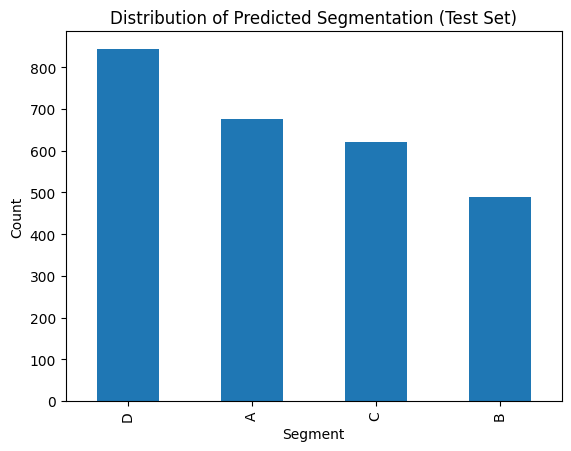

In [109]:
test['Predicted_Segmentation'].value_counts().plot(kind='bar')

plt.title("Distribution of Predicted Segmentation (Test Set)")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.show()

# **Business Conclusion – Customer Segmentation Prediction**

Berdasarkan proses klasifikasi menggunakan model terbaik **Gradient Boosting**, dilakukan prediksi terhadap **2.627 calon pelanggan baru** untuk menentukan segmen yang paling sesuai (A, B, C, atau D).

Hasil analisis distribusi prediksi menunjukkan:

* **Segmen D** adalah yang paling dominan
* Diikuti oleh **Segmen A**, lalu **Segmen C**
* **Segmen B** menjadi yang paling sedikit

Distribusi ini memberikan gambaran penting bagi perusahaan dalam menyusun strategi pemasaran di pasar baru.

---

# **1. Implikasi Bisnis Utama**

## **a) Segmen D mendominasi pasar baru**

Dengan mayoritas calon pelanggan berada di Segmen D, perusahaan dapat:

* Mengalokasikan **anggaran pemasaran terbesar** untuk strategi komunikasi yang cocok dengan karakter Segmen D.
* Menyusun **produk bundling, promo, atau penawaran khusus** yang sesuai preferensi segmen ini.
* Menyesuaikan channel pemasaran yang biasanya efektif untuk pelanggan Segmen D (misal: media sosial tertentu, kampanye digital, diskon besar, atau layanan value-for-money).

Segmen D kemungkinan merupakan segmen yang paling mudah diakuisisi di pasar baru.

## **b) Segmen A sebagai target potensial kedua**

Segmen A cukup besar, sehingga:

* Perusahaan dapat merancang **strategi pemasaran khusus** yang lebih premium atau lebih berorientasi kualitas.
* Sales pipeline dapat dibuat terpisah untuk Segmen A untuk meningkatkan konversi.

Segmentasi A bisa memberikan **margin keuntungan lebih tinggi**, sehingga layak menjadi fokus kedua.

## **c) Segmen C berukuran menengah → cocok untuk strategi retensi**

Segmen C tidak terlalu besar namun masih signifikan.
Strateginya:

* Fokus pada **personalized offers**
* Kampanye edukasi produk untuk meningkatkan engagement
* Program loyalitas jangka panjang

Segmen C dapat menjadi basis pelanggan stabil dalam jangka waktu panjang.

## **d) Segmen B paling kecil → perlu pendekatan berbeda**

Segmen B adalah kelompok paling kecil dalam prediksi.
Interpretasi dan tindakan:

* Mungkin calon pelanggan di pasar baru **tidak cocok** dengan karakter segmen B.
* Perusahaan perlu melakukan **riset tambahan** untuk memahami hambatan pada segmen ini.
* Pemasaran bisa dilakukan lebih selektif agar biaya tidak terbuang percuma.

---

# **2. Rekomendasi Strategi Pemasaran Berdasarkan Hasil Model**
- **Segmen D** = Pasar paling mudah penetrasi (bisa dengan Promo, diskon, kampanye digital agresif)
- **Segmen A** = Potensi profit tinggi (Dengan Penawaran premium, kualitas layanan)
- **Segmen C** = Basis pelanggan stabil (Dengan Loyalitas, edukasi produk)
- **Segmen B** = Perlu pendekatan khusus (Dengan Riset tambahan, pemasaran selektif)

---

# **3. Nilai bisnis dari model ini**

Dengan hasil segmentasi yang sudah diprediksi:

* Tim sales dapat **memprioritaskan pendekatan** ke segmen yang lebih besar (D → A → C).
* Perusahaan dapat **menghemat biaya pemasaran** karena targeting lebih tepat.
* Strategi komunikasi dapat disesuaikan sejak awal sehingga **probabilitas konversi meningkat**.
* Perusahaan dapat membuat **forecast penjualan** lebih akurat berdasarkan proporsi tiap segmen.
* Model ini membantu perusahaan **memahami karakteristik pasar baru** tanpa harus menunggu data historis.

---

# **4. Kesimpulan Akhir**

Proses klasifikasi berhasil memberikan wawasan penting bagi perusahaan otomotif dalam memasuki pasar baru. Dengan memahami dominasi Segmen D serta proporsi segmen lain, perusahaan dapat menyusun strategi pemasaran yang lebih terarah, efektif, dan hemat biaya.

Model Gradient Boosting memberikan performa terbaik dan mampu membantu perusahaan melakukan targeting pelanggan baru dengan akurasi tinggi.
